In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import axes
import pickle
from datetime import datetime
from scipy import log,exp,sqrt,stats
print('Packages')

Packages


In [2]:
# Importing pickle file
data1 = np.load('latest_coin_data.pkl')
data2 = np.load('additional_data.pkl')

# Removing July dates from data1
data1 = data1.drop(data1.columns[0:4], axis = 1)

# Combining the two dataframes
data = pd.concat([data2, data1], axis = 1, join = 'outer', sort = True)

# Filling Nan values with 0
data = data.dropna()

# Saving original date index
date_index = data.columns

print('Loading of Data')
print('shape of data: ', data.shape)

Loading of Data
shape of data:  (127, 947)


In [3]:
print('Getting Market Caps')
# Initialize a close_price list
mc_list = list()
# Making a list of all close_prices
for date in data.index:
    for column in data.columns:
        mc_list.append(data[column][date]['market_cap'])

Getting Market Caps


In [4]:
print('Making Market Cap dataframe')
# Splitting list into 133 lists (one per coin)
mc_list = [mc_list[i:i+947] for i  in range(0, len(mc_list), 947)]   
# Making dataframe
mc_data = pd.DataFrame(data = mc_list, index = data.index, columns = data.columns)

Making Market Cap dataframe


In [5]:
print('Getting Close Prices')
# Initialize a close_price list
cp_list = list()
# Making a list of all close_prices
for date in data.index:
    for column in data.columns:
        cp_list.append(data[column][date]['close_price'])

Getting Close Prices


In [6]:
print('Making Close Price dataframe')
# Splitting list into 133 lists (one per coin)
cp_list = [cp_list[i:i+947] for i  in range(0, len(cp_list), 947)]   
# Making dataframe
close_data = pd.DataFrame(data = cp_list, index = data.index, columns = data.columns)

Making Close Price dataframe


In [7]:
print('flipping the dates in order')
# Reording the date index
close_data = close_data[close_data.columns[::-1]]
mc_data = mc_data[mc_data.columns[::-1]]
data = data[data.columns[::-1]]

flipping the dates in order


In [8]:
print('Share cap functions')

def share_cap_recurse(market_cap_list, num_coins, cap_ceiling_amount, final_cap_list):

    not_realloc_val = 0

    realloc_val = 0

    num_final = 0

    new_market_cap_list = []

    

    for i in range(0, len(market_cap_list)):

        if(market_cap_list[i] > cap_ceiling_amount):

            final_cap_list.append(cap_ceiling_amount)

            realloc_val += market_cap_list[i] - cap_ceiling_amount

            num_final += 1

        else:

            not_realloc_val += market_cap_list[i]

     

    if(num_final!=0):

        new_market_cap_list = [x * (1+(realloc_val/not_realloc_val)) for x in market_cap_list[num_final:]]

    else:

        new_market_cap_list = deepcopy(market_cap_list)

    

    if len(final_cap_list) == num_coins:

        return

    elif (new_market_cap_list[0] <= cap_ceiling_amount): #assumes ordered desc in market cap

        for cap in new_market_cap_list:

            final_cap_list.append(cap)

        return       

    else:

        share_cap_recurse(new_market_cap_list, num_coins, cap_ceiling_amount, final_cap_list)

        

def share_cap(market_cap_list, cap_ceiling_percent):  #CHANGE CAP CEILING HERE

    total_cap = sum(market_cap_list)

    cap_ceiling_amount = total_cap * cap_ceiling_percent

    final_cap_list = []

    

    share_cap_recurse(market_cap_list, len(market_cap_list), cap_ceiling_amount, final_cap_list)

    

    return (final_cap_list)

Share cap functions


In [9]:
# Selecting dates and median market caps
selectedmarket = mc_data.copy()
selectedmarket = selectedmarket.loc[:, 'Jul 01, 2017':'Jul 01, 2018':7]
# selectedmarket = selectedmarket.resample('W',axis=1).median()

# Selecting dates and median close price
selectedclose = close_data.copy()
selectedclose = selectedclose.loc[:, 'Jul 01, 2017':'Jul 01, 2018':7]
# selectedclose = selectedclose.resample('W',axis=1).median()

# Daily close prices
dailyclose = close_data.loc[:,'Jul 01, 2017':'Jul 01, 2018']
dailyclose1 = dailyclose.copy().T
dailychanget = dailyclose1.pct_change(1).T
dailychange = dailyclose1.pct_change(1).T

# Calculating percent change for returns
selectedclose1 = selectedclose.copy().T
selectedreturns = selectedclose1.pct_change(1).T
selectedreturns.head()
print('selected market, selectedclose, dailychange and selectedreturns')

selected market, selectedclose, dailychange and selectedreturns


In [10]:
print('Total market cap movement for tethershare')
tmc_list = list()

for column in selectedmarket.columns:
    tmc_list.append(selectedmarket[column].sum())
    
tmc_data = pd.DataFrame(data = tmc_list, columns = ['total_mc'])
tmc_data.index = selectedmarket.columns
tmc_pct = tmc_data.pct_change(1)

# Resampling the tmc data to get weekly
tmc_pct = tmc_pct.loc['Jul 01, 2017':'Jun 30, 2018',:]
# tmc_pct = tmc_pct.resample('W').median()
tmc_pct_index = tmc_pct.index

tmc_pct.head(5)

Total market cap movement for tethershare


,total_mc
"Jul 01, 2017",NaN
"Jul 08, 2017",-0.056833
"Jul 15, 2017",-0.152925
"Jul 22, 2017",0.140825
"Jul 29, 2017",-0.010164


In [11]:
print('tether share allocations per week')

num_index = np.arange(53)
tmc_pct.index = num_index

usdt_share = {}
usdt_share[0] = 0.10      #USDT starts off with ___% for the date


for i in tmc_pct.index[1:]:
    if tmc_pct['total_mc'][i] < -0.01:
        usdt_share[i] = usdt_share[i -1] - 3*(tmc_pct['total_mc'][i])
        if usdt_share[i] >= 1.00:
            usdt_share[i] = 1.00
    elif tmc_pct['total_mc'][i] > 0.01: 
        usdt_share[i] = usdt_share[i -1] - 3*(tmc_pct['total_mc'][i])
        if usdt_share[i] <= 0:
            usdt_share[i] = 0
    else:
        usdt_share[i] = usdt_share[i -1]

tether share allocations per week


In [12]:
# print('tether share allocations per week')

# num_index = np.arange(53)
# tmc_pct.index = num_index

# usdt_share = {}
# usdt_share[0] = 0.10      #USDT starts off with ___% for the date


# for i in tmc_pct.index[1:]:
#     if tmc_pct['total_mc'][i] < -0.01:
#         usdt_share[i] = usdt_share[i -1] + 0.02
#         if usdt_share[i] >= 1.00:
#             usdt_share[i] = 1.00
#     elif tmc_pct['total_mc'][i] > 0.01: 
#         usdt_share[i] = usdt_share[i -1] - 0.02
#         if usdt_share[i] <= 0:
#             usdt_share[i] = 0
#     else:
#         usdt_share[i] = usdt_share[i -1]

In [13]:
ilist = range(0, len(tmc_pct))

tethershare = {}
         
for (i, column) in zip(ilist, selectedmarket):
    tethershare[column] = usdt_share[i]
         
print('setting tethershare labels to match dates')

setting tethershare labels to match dates


In [14]:
print('usdt_close prices and usdt_retruns (pct change)')
usdt_close = pd.DataFrame(data = dailyclose.loc['tether'])
usdt_returns = usdt_close.pct_change(1)
usdt_returns.head(5)

usdt_close prices and usdt_retruns (pct change)


,tether
"Jul 01, 2017",NaN
"Jul 02, 2017",0.000000
"Jul 03, 2017",-0.019608
"Jul 04, 2017",-0.001172
"Jul 05, 2017",-0.002371


In [15]:
print('loop for C10 with tether market cap function')
#FOR LOOP FOR C10 with tether
topmc10t = {}
sc10t = {}
tc10t = {}
ps10t = {}
invest10t = {}
returns10t = {}
lg_returns10t = {}
selectedmc10t = {}
topcoins10t = {}
c10sharet = {}
usdt_returnst = {}
daily_usdt_returnst = {}

daily_changet = {}
weighted_daily_changet = {}
daily_returnst = {}
c10t_returns = list()
tether_returns = list()


#for every date
for column in selectedmarket:
    #sort in descending order
    selectedmc10t[column] = selectedmarket[column].sort_values(ascending=False)
    
    #take the top coins
    topmc10t[column] = selectedmc10t[column].head(10)
    #take the index of the top coins
    topcoins10t[column] = topmc10t[column].index
    
    #get the share cap of the top 10
    sc10t[column] = share_cap(topmc10t[column], 0.15)      #CHOICE OF CAP CEILING
    
    #total cap of top 10
    tc10t[column] = sum(sc10t[column])
    
    #percentage of total fund allocated to tether/C10- NEW CODE!!
    c10tfund = 1 - tethershare[column]
    
    #percentage share to be allocated for top 10 - NEW CODE!!!
    ps10t[column] = [x * c10tfund / tc10t[column] for x in sc10t[column] ]
    
    #building dataframe of top20 coins by mc and %share to be invested
    invest10t[column] = pd.DataFrame()
    invest10t[column] = pd.DataFrame({'coin': topcoins10t[column], 'pct_share': ps10t[column]})
    invest10t[column] = invest10t[column].set_index('coin')
    
jlist = list(range(0,365,7))
    
for (j, column) in zip(jlist, selectedmarket):
    daily_changet[column] = pd.DataFrame()
    daily_changet[column] = pd.DataFrame(data = dailychanget.iloc[:,j:j+7])
    daily_changet[column] = daily_changet[column].loc[topcoins10t[column]]
    weighted_daily_changet[column] = daily_changet[column].mul(ps10t[column], axis=0)
    
    daily_returnst[column] = weighted_daily_changet[column].sum()
    daily_returnst[column].columns = ['daily_returns']
    
    
    usdt_returnst[column] = pd.DataFrame()
    usdt_returnst[column] = pd.DataFrame(data = usdt_returns.iloc[j:j+7,:])
    daily_usdt_returnst[column] = usdt_returnst[column].mul(tethershare[column], axis = 0)
    
    c10t_returns.extend(daily_returnst[column])
    tether_returns.extend(daily_usdt_returnst[column]['tether'])


loop for C10 with tether market cap function


In [16]:
print('loop for C10 with tether market cap function')
#FOR LOOP FOR C10 with tether
topmc10 = {}
sc10 = {}
tc10 = {}
ps10 = {}
invest10 = {}
returns10 = {}
lg_returns10 = {}
selectedmc10 = {}
topcoins10 = {}
c10share = {}
usdt_returns = {}
daily_usdt_returns = {}

daily_change = {}
weighted_daily_change = {}
daily_returns = {}
c10_returns = list()


#for every date
for column in selectedmarket:
    #sort in descending order
    selectedmc10[column] = selectedmarket[column].sort_values(ascending=False)
    
    #take the top coins
    topmc10[column] = selectedmc10[column].head(10)
    #take the index of the top coins
    topcoins10[column] = topmc10[column].index
    
    #get the share cap of the top 10
    sc10[column] = share_cap(topmc10[column], 0.15)      #CHOICE OF CAP CEILING
    
    #total cap of top 10
    tc10[column] = sum(sc10[column])
    
    #percentage share to be allocated for top 10 - NEW CODE!!!
    ps10[column] = [x / tc10[column] for x in sc10[column] ]
    
    #building dataframe of top20 coins by mc and %share to be invested
    invest10[column] = pd.DataFrame()
    invest10[column] = pd.DataFrame({'coin': topcoins10[column], 'pct_share': ps10[column]})
    invest10[column] = invest10[column].set_index('coin')
    
jlist = list(range(0,365,7))
    
for (j, column) in zip(jlist, selectedmarket):
    daily_change[column] = pd.DataFrame()
    daily_change[column] = pd.DataFrame(data = dailychange.iloc[:,j:j+7])
    daily_change[column] = daily_change[column].loc[topcoins10[column]]
    weighted_daily_change[column] = daily_change[column].mul(ps10[column], axis=0)
    
    daily_returns[column] = weighted_daily_change[column].sum()
    daily_returns[column].columns = ['daily_returns']

    c10_returns.extend(daily_returns[column])

loop for C10 with tether market cap function


In [17]:
c10t_returns_df = pd.DataFrame(data = c10t_returns, index = dailychange.columns, 
                               columns = ['c10t'])
c10t_returns_df['tether'] = tether_returns
c10t_returns_df['c10t+tether'] = c10t_returns_df['tether'] + c10t_returns_df['c10t']

c10t_returns_df['c10'] = c10_returns

c10t_returns_df.head(5)

,c10t,tether,c10t+tether,c10
"Jul 01, 2017",0.000000,NaN,NaN,0.000000
"Jul 02, 2017",0.036292,0.000000,0.036292,0.040324
"Jul 03, 2017",0.043125,-0.001961,0.041164,0.047916
"Jul 04, 2017",0.028673,-0.000117,0.028556,0.031859
"Jul 05, 2017",0.000603,-0.000237,0.000366,0.000670


In [18]:
c10t_returns_df['c10t_cum'] = (1 + c10t_returns_df['c10t+tether']).cumprod()
c10t_returns_df['c10_cum'] = (1 + c10t_returns_df['c10']).cumprod()
c10t_returns_df.head(5)

,c10t,tether,c10t+tether,c10,c10t_cum,c10_cum
"Jul 01, 2017",0.000000,NaN,NaN,0.000000,NaN,1.000000
"Jul 02, 2017",0.036292,0.000000,0.036292,0.040324,1.036292,1.040324
"Jul 03, 2017",0.043125,-0.001961,0.041164,0.047916,1.078950,1.090173
"Jul 04, 2017",0.028673,-0.000117,0.028556,0.031859,1.109760,1.124904
"Jul 05, 2017",0.000603,-0.000237,0.000366,0.000670,1.110166,1.125658


In [19]:
c10t_returns_df.at['Jul 01, 2017','c10+tether'] = 1
c10t_returns_df.at['Jul 01, 2017','c10'] = 1
c10t_returns_df.at['Jul 01, 2017','c10_cum'] = 1
c10t_returns_df.at['Jul 01, 2017','c10t_cum'] = 1
c10t_returns_df.head(10)

,c10t,tether,c10t+tether,c10,c10t_cum,c10_cum,c10+tether
"Jul 01, 2017",0.000000,NaN,NaN,1.000000,1.000000,1.000000,1.0
"Jul 02, 2017",0.036292,0.000000,0.036292,0.040324,1.036292,1.040324,NaN
"Jul 03, 2017",0.043125,-0.001961,0.041164,0.047916,1.078950,1.090173,NaN
"Jul 04, 2017",0.028673,-0.000117,0.028556,0.031859,1.109760,1.124904,NaN
"Jul 05, 2017",0.000603,-0.000237,0.000366,0.000670,1.110166,1.125658,NaN
"Jul 06, 2017",-0.005157,0.000355,-0.004802,-0.005730,1.104836,1.119208,NaN
"Jul 07, 2017",-0.072035,0.001000,-0.071035,-0.080038,1.026354,1.029629,NaN
"Jul 08, 2017",0.025928,-0.002752,0.023176,0.035542,1.050141,1.066224,NaN
"Jul 09, 2017",-0.027777,0.002780,-0.024996,-0.038076,1.023891,1.025626,NaN
"Jul 10, 2017",-0.074677,0.000000,-0.074677,-0.102368,0.947430,0.920635,NaN


In [20]:
c10t_returns_df['c10t+tether'].std(axis = 0)

0.03938238929571073

In [21]:
tether_allocations = pd.DataFrame(data = tethershare, index = tethershare.keys())
tether_allocations = tether_allocations.drop(tether_allocations.index[1:])
tether_allocations = tether_allocations.T
tether_allocations.columns = ['tether_share']
tether_allocations.head(5)

,tether_share
"Jul 01, 2017",0.100000
"Jul 08, 2017",0.270499
"Jul 15, 2017",0.729274
"Jul 22, 2017",0.306798
"Jul 29, 2017",0.337291


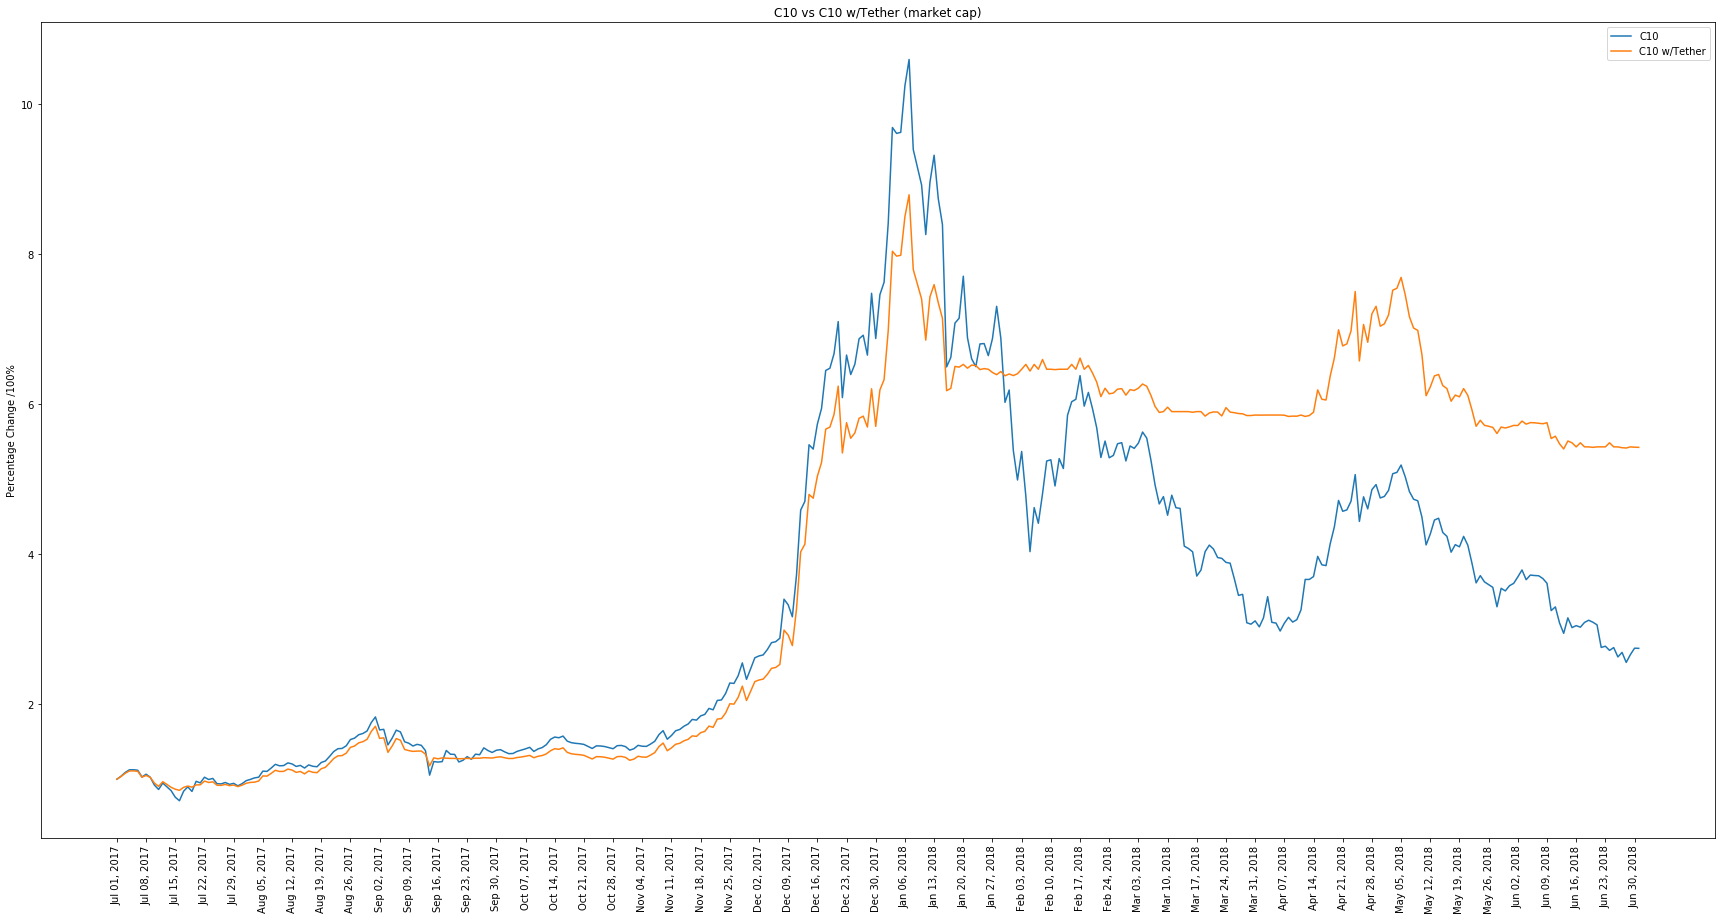

In [24]:
plt.ylabel('Percentage Change /100%')
plt.rcParams['figure.figsize'] = (30,15)
plt.plot(c10t_returns_df['c10_cum'], label="C10")
plt.plot(c10t_returns_df['c10t_cum'], label="C10 w/Tether")
plt.xticks(np.arange(0,365,step=7), rotation=90)
plt.title('C10 vs C10 w/Tether (market cap)')
plt.legend()
plt.show()

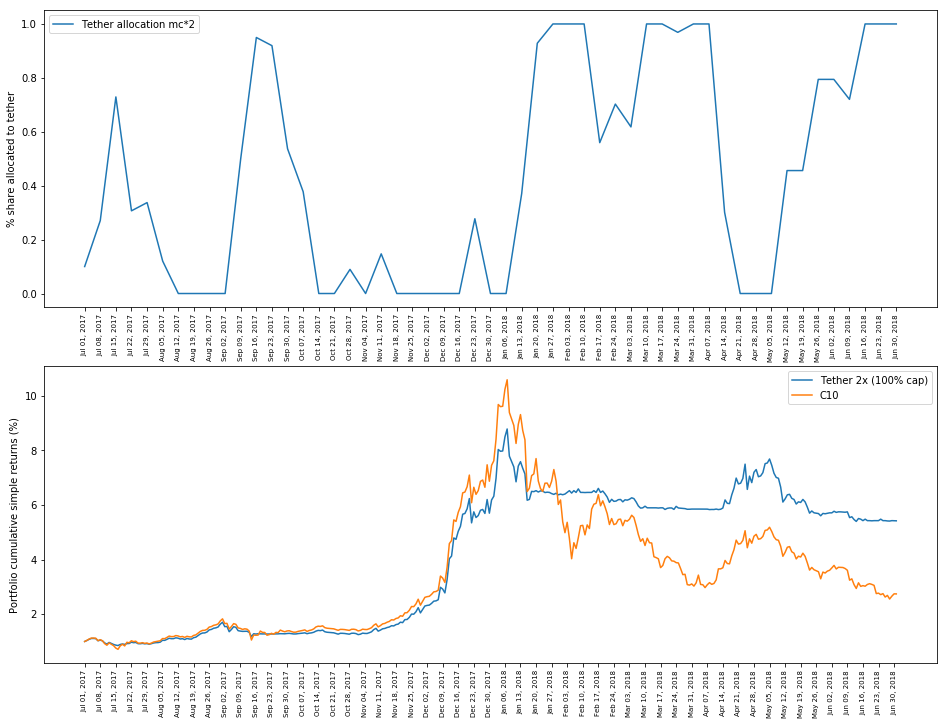

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,12))
ax1.plot(tether_allocations.index, tether_allocations, label = "Tether allocation mc*2")
ax1.set_ylabel('% share allocated to tether')

ax2.plot(c10t_returns_df.index, c10t_returns_df['c10t_cum'], label = "Tether 2x (100% cap)")
ax2.plot(c10t_returns_df.index, c10t_returns_df['c10_cum'], label = "C10")
ax2.set_ylabel('Portfolio cumulative simple returns (%)')


ax2.set_xticks(np.arange(0,365,step=7))

ax1.set_xticklabels(tether_allocations.index ,rotation=90, fontsize = 7)
ax2.set_xticklabels(tether_allocations.index ,rotation=90, fontsize = 7)

labels = [item.get_text() for item in mpl.axes.Axes.get_xticklabels(ax2)]

ax1.legend()
ax2.legend()

plt.show()

In [24]:
print('Monthly returns growth')
# Resampling the two returns by month
monthly_returns = pd.DataFrame(data = [c10t_returns_df['c10_cum'], 
                                       c10t_returns_df['c10t_cum']],)
monthly_returns.columns = pd.to_datetime(monthly_returns.columns)
monthly_returns = monthly_returns.T
monthly_df = monthly_returns.resample('MS').asfreq()[0:13]


monthly_df.head(13)

Monthly returns growth


,c10_cum,c10t_cum
2017-07-01,1.000000,1.000000
2017-08-01,0.980316,0.948843
2017-09-01,1.829290,1.756159
2017-10-01,1.393434,1.343286
2017-11-01,1.386734,1.318624
2017-12-01,2.617605,2.423075
2018-01-01,7.620507,6.660856
2018-02-01,5.379348,6.718447
2018-03-01,5.440127,6.419426
2018-04-01,3.029423,5.793131


In [25]:
print('Monthly Returns 2*MC, 100% cap')
monthly_df2 = (monthly_df - monthly_df.shift(1))/monthly_df.shift(1)
monthly_df2.shift(-1)

Monthly Returns 2*MC, 100% cap


,c10_cum,c10t_cum
2017-07-01,-0.019684,-0.051157
2017-08-01,0.866020,0.850843
2017-09-01,-0.238265,-0.235100
2017-10-01,-0.004808,-0.018360
2017-11-01,0.887604,0.837579
2017-12-01,1.911252,1.748927
2018-01-01,-0.294096,0.008646
2018-02-01,0.011299,-0.044507
2018-03-01,-0.443134,-0.097562
2018-04-01,0.573782,0.279342


In [ ]:
monthly_df2.to_csv('2%100.csv')